In [2]:
import pandas as pd
import numpy as np
import time
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import ParameterGrid

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

In [5]:
# ==== Load and Prepare Data ====
samples = pd.read_csv(r'D:\Nam3\HK2\ATBM\DDOS\Dataset\export_dataframe_proc.csv')
tests = pd.read_csv(r'D:\Nam3\HK2\ATBM\DDOS\Dataset\export_tests_proc.csv')

X_train = samples.iloc[:, :-1]
y_train = samples.iloc[:, -1]
X_test = tests.iloc[:, :-1]
y_test = tests.iloc[:, -1]

# Upsample minority class
df = pd.concat([X_train, y_train], axis=1)
normal = df[df['Label'] == 0]
ddos = df[df['Label'] == 1]
normal_upsampled = resample(normal, replace=True, n_samples=len(ddos), random_state=27)
upsampled = pd.concat([normal_upsampled, ddos])
X_train = upsampled.iloc[:, :-1]
y_train = upsampled.iloc[:, -1]

# Normalize
scaler = MinMaxScaler((-1, 1)).fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Format input 3D for GRU
def format_3d(X):
    return np.reshape(np.array(X), (X.shape[0], X.shape[1], 1))

X_train_3d = format_3d(X_train)
X_test_3d = format_3d(X_test)

# ==== GRU Model Definition ====
def GRU_model(input_size):
    model = Sequential()
    model.add(GRU(32, input_shape=(input_size, 1)))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model


In [7]:
def full_evaluation(model, X_train, y_train, X_test, y_test, epochs, batch_size, learning_rate):
    start = time.time()
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    train_time = time.time() - start

    # Dự đoán xác suất
    y_prob = model.predict(X_test).flatten()  # Mô hình trả về xác suất

    # Dự đoán nhị phân
    y_pred = (y_prob > 0.5).astype(int)

    # Detection rates
    true_normal = (y_test == 0)
    true_attack = (y_test == 1)
    normal_detect_rate = (y_pred[true_normal] == 0).sum() / true_normal.sum()
    attack_detect_rate = (y_pred[true_attack] == 1).sum() / true_attack.sum()

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)  # Sử dụng xác suất thay vì nhãn nhị phân
    roc_auc = auc(fpr, tpr)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Normal_Detect_Rate': normal_detect_rate,
        'Atk_Detect_Rate': attack_detect_rate,
        'epochs': epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'Training_Time': train_time,
        'Confusion_Matrix': cm.tolist(),
        'ROC_FPR': fpr.tolist(),
        'ROC_TPR': tpr.tolist(),
        'ROC_AUC': roc_auc
    }

# ==== Grid Search ====
from sklearn.model_selection import ParameterGrid

param_grid = {
    'epochs': [5, 10],
    'batch_size': [64, 128],
    'learning_rate': [0.001, 0.0005]
}

results = []
for params in ParameterGrid(param_grid):
    print(f"Training GRU with params: {params}")
    model = GRU_model(X_train.shape[1])  # Gọi mô hình GRU
    result = full_evaluation(
        model, X_train_3d, y_train,
        X_test_3d, y_test,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        learning_rate=params['learning_rate']
    )
    results.append(result)

Training GRU with params: {'batch_size': 64, 'epochs': 5, 'learning_rate': 0.001}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step
Training GRU with params: {'batch_size': 64, 'epochs': 5, 'learning_rate': 0.0005}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step
Training GRU with params: {'batch_size': 64, 'epochs': 10, 'learning_rate': 0.001}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step
Training GRU with params: {'batch_size': 64, 'epochs': 10, 'learning_rate': 0.0005}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step
Training GRU with params: {'batch_size': 128, 'epochs': 5, 'learning_rate': 0.001}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step
Training GRU with params: {'batch_size': 128, 'epochs': 5, 'learning_rate': 0.0005}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step
Training GRU with params: {'batch_size': 128, 'epochs': 10, 'learning_rate': 0.001}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Training GRU with params: {'batch_size': 128, 'epochs': 10, 'learning_rate': 0.0005}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step


In [8]:
# ==== Save All Results (excluding ROC) ====
df_results_gru = pd.DataFrame([
    {k: v for k, v in res.items() if k not in ['ROC_FPR', 'ROC_TPR']} for res in results
])

df_results_gru.to_csv(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\GRU\gru_gridsearch_results.csv', index=False)

# ==== Save Best Model Result ====
best_index_gru = df_results_gru['Accuracy'].idxmax()
best_model_result_gru = results[best_index_gru]  # Lấy bản đầy đủ để có ROC
best_model_df_gru = pd.DataFrame([{
    k: v for k, v in best_model_result_gru.items() if k not in ['ROC_FPR', 'ROC_TPR']
}])

print("\nBest Hyperparameters (GRU - Highest Accuracy):")
for param in best_model_df_gru.columns:
    print(f"{param}: {best_model_df_gru[param][0]}")

best_model_df_gru.to_csv(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\GRU\gru_best_results.csv', index=False)

# ==== Save ROC for Best Model ====
np.save(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\GRU\best_model_roc_fpr.npy', np.array(best_model_result_gru['ROC_FPR']))
np.save(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\GRU\best_model_roc_tpr.npy', np.array(best_model_result_gru['ROC_TPR']))
np.save(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\GRU\best_model_roc_auc.npy', best_model_result_gru['ROC_AUC'])



Best Hyperparameters (GRU - Highest Accuracy):
Accuracy: 0.9992188185728078
Precision: 0.9997190202235194
Recall: 0.9993434565083823
F1-Score: 0.9995312030873876
Normal_Detect_Rate: 0.9985956288949355
Atk_Detect_Rate: 0.9993434565083823
epochs: 10
batch_size: 64
learning_rate: 0.001
Training_Time: 1203.253806591034
Confusion_Matrix: [[56885, 80], [187, 284638]]
ROC_AUC: 0.999950561342049


In [3]:
# Read the results into a DataFrame (for plotting purposes only)
grid_df = pd.read_csv(r"gru_gridsearch_results.csv")

In [4]:
grid_df = pd.DataFrame(grid_df)
print("==== Grid Search Results for GRU ====")
grid_df

==== Grid Search Results for GRU ====


,Accuracy,Precision,Recall,F1-Score,Normal_Detect_Rate,Atk_Detect_Rate,epochs,batch_size,learning_rate,Training_Time,Confusion_Matrix,ROC_AUC
0,0.999143,0.999081,0.999891,0.999486,0.995401,0.999891,5,64,0.0010,766.457011,"[[56703, 262], [31, 284794]]",0.999764
1,0.978147,0.990798,0.982905,0.986836,0.954358,0.982905,5,64,0.0005,657.036370,"[[54365, 2600], [4869, 279956]]",0.997632
2,0.999219,0.999719,0.999343,0.999531,0.998596,0.999343,10,64,0.0010,1203.253807,"[[56885, 80], [187, 284638]]",0.999951
3,0.997235,0.996982,0.999709,0.998343,0.984868,0.999709,10,64,0.0005,1213.977313,"[[56103, 862], [83, 284742]]",0.998904
4,0.998719,0.999287,0.999175,0.999231,0.996436,0.999175,5,128,0.0010,453.323228,"[[56762, 203], [235, 284590]]",0.999214
5,0.998081,0.998268,0.999431,0.998849,0.991328,0.999431,5,128,0.0005,450.789456,"[[56471, 494], [162, 284663]]",0.998565
6,0.991363,0.990649,0.999066,0.994840,0.952848,0.999066,10,128,0.0010,1075.973286,"[[54279, 2686], [266, 284559]]",0.998981
7,0.995819,0.999278,0.995703,0.997487,0.996401,0.995703,10,128,0.0005,1084.881061,"[[56760, 205], [1224, 283601]]",0.999239


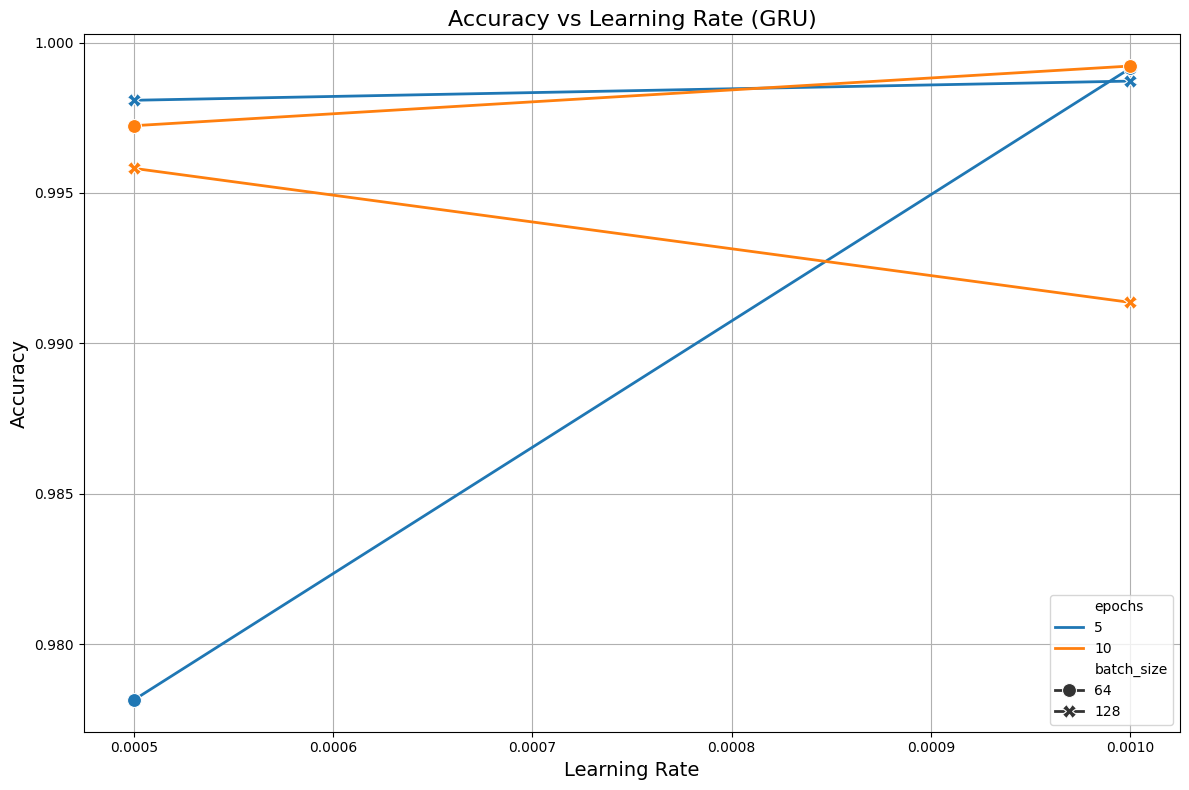

In [3]:
plt.figure(figsize=(12, 8))

# Plot Accuracy vs Learning Rate, grouped by epochs, styled by batch_size
sns.lineplot(
    data=grid_df,
    x='learning_rate',
    y='Accuracy',
    hue='epochs',
    style='batch_size',
    markers=True,
    palette='tab10',  # Different palette for Accuracy
    markersize=10,
    linewidth=2,
    dashes=False,
    errorbar=None
)

# Adding title and labels for Accuracy plot
plt.title("Accuracy vs Learning Rate (GRU)", fontsize=16)
plt.xlabel("Learning Rate", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)

# Adjust grid and layout for Accuracy plot
plt.grid(True)
plt.tight_layout()

# Show the Accuracy plot
plt.show()

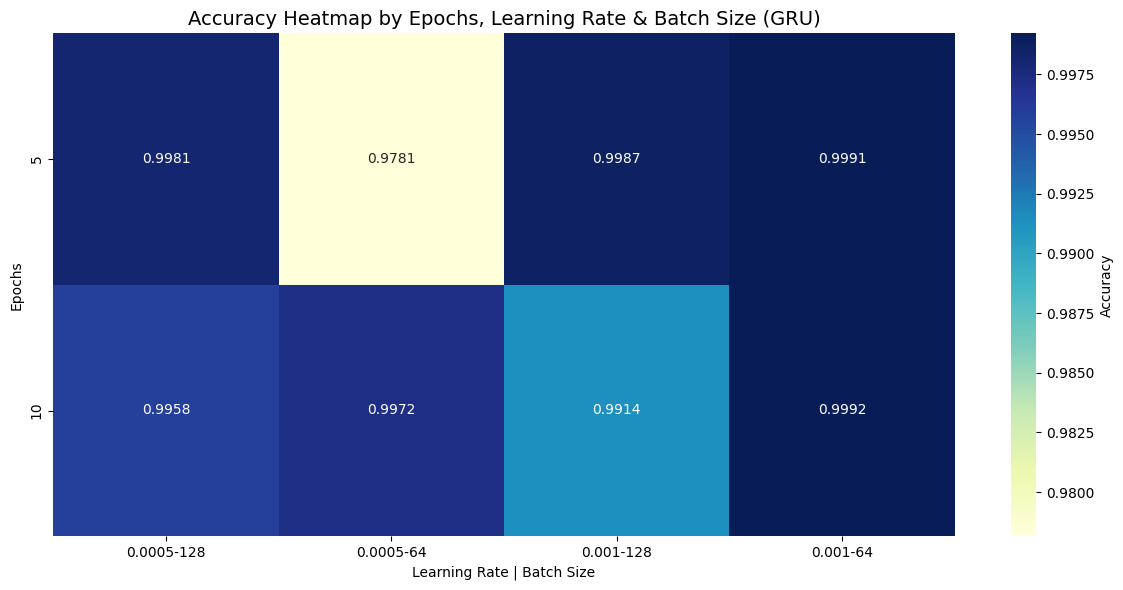

In [4]:
grid_df['learning_rate'] = grid_df['learning_rate'].astype(str)
grid_df['batch_size'] = grid_df['batch_size'].astype(str)

# Create a pivot table with MultiIndex columns: (learning_rate, batch_size)
heatmap_data = grid_df.pivot_table(
    index='epochs',
    columns=['learning_rate', 'batch_size'],
    values='Accuracy',
    aggfunc='mean'
)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Accuracy'}
)

plt.title("Accuracy Heatmap by Epochs, Learning Rate & Batch Size (GRU)", fontsize=14)
plt.xlabel("Learning Rate | Batch Size")
plt.ylabel("Epochs")
plt.tight_layout()
plt.show()

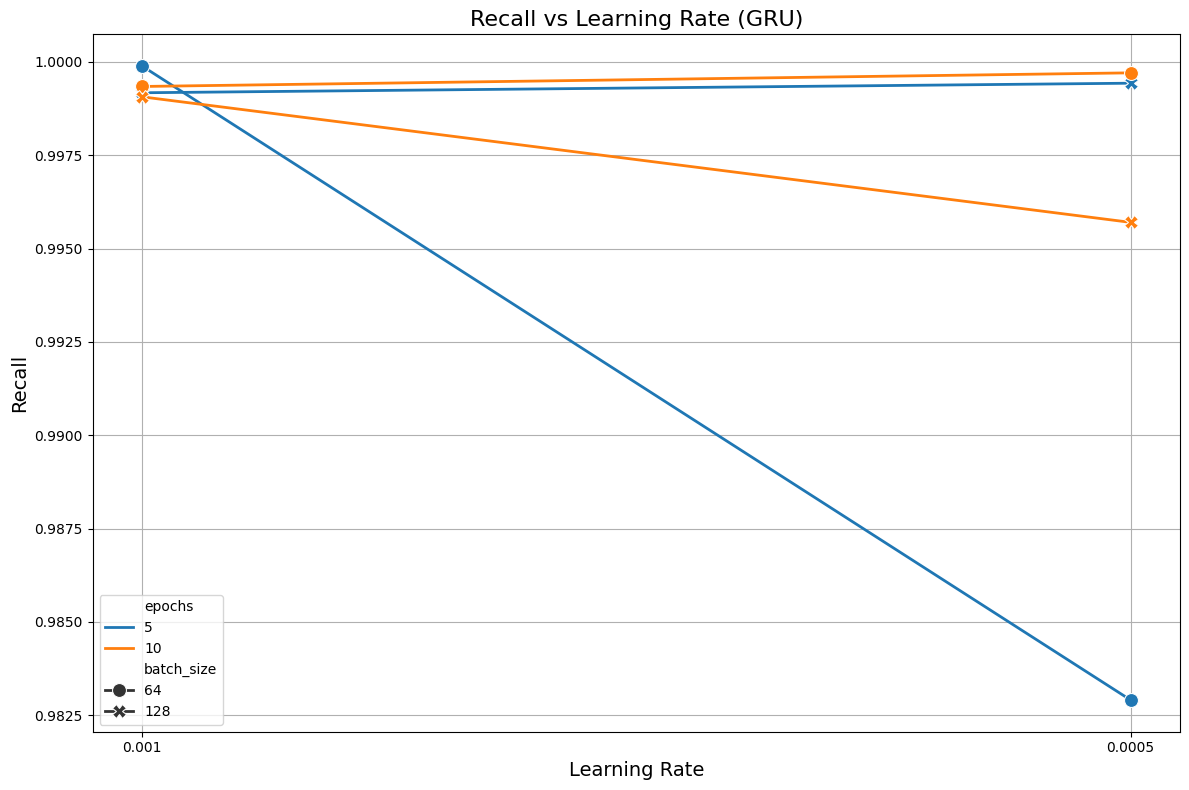

In [5]:
plt.figure(figsize=(12, 8))

# Plot Recall vs Learning Rate, grouped by epochs, styled by batch_size
sns.lineplot(
    data=grid_df,
    x='learning_rate',
    y='Recall',
    hue='epochs',
    style='batch_size',
    markers=True,
    palette='tab10',
    markersize=10,
    linewidth=2,
    dashes=False,
    errorbar=None
)

# Add title and labels
plt.title("Recall vs Learning Rate (GRU)", fontsize=16)
plt.xlabel("Learning Rate", fontsize=14)
plt.ylabel("Recall", fontsize=14)

# Adjust grid and layout
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

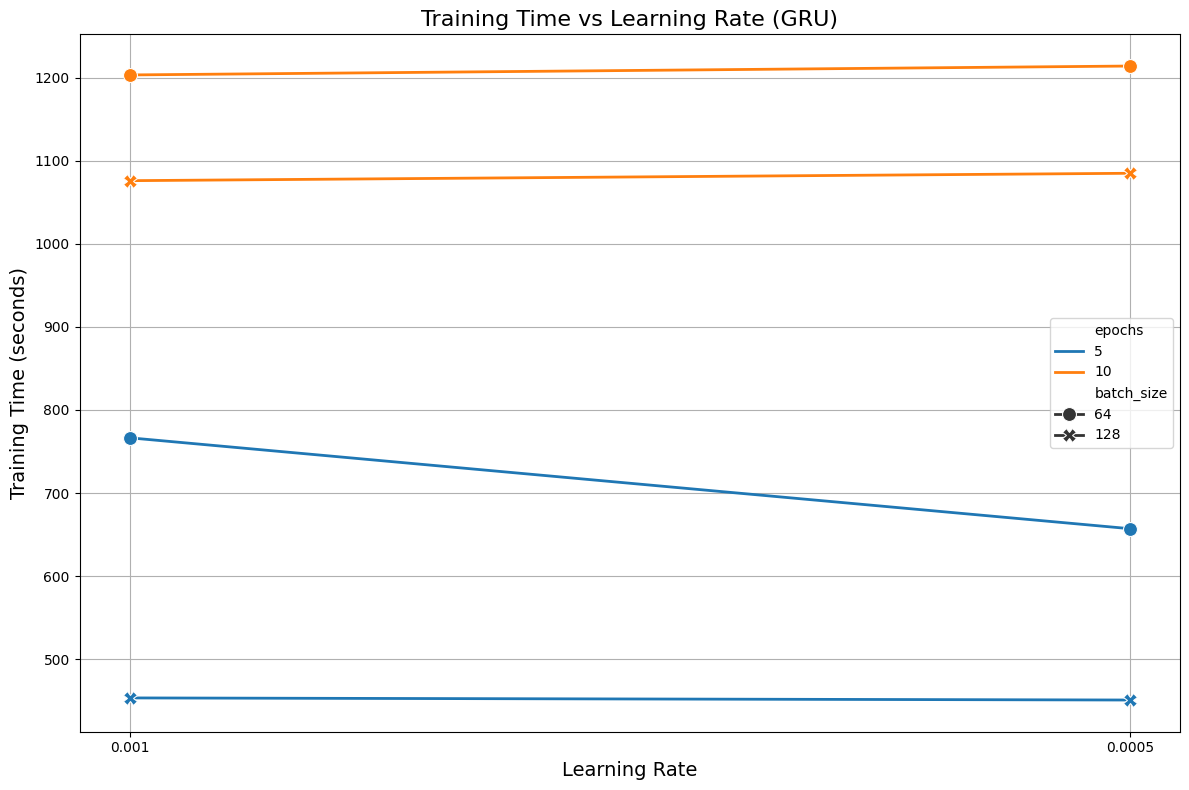

In [6]:
plt.figure(figsize=(12, 8))

# Plot Training Time vs Learning Rate, grouped by epochs, styled by batch_size
sns.lineplot(
    data=grid_df,
    x='learning_rate',
    y='Training_Time',
    hue='epochs',
    style='batch_size',
    markers=True,
    palette='tab10',
    markersize=10,
    linewidth=2,
    dashes=False,
    errorbar=None
)

# Add title and labels
plt.title("Training Time vs Learning Rate (GRU)", fontsize=16)
plt.xlabel("Learning Rate", fontsize=14)
plt.ylabel("Training Time (seconds)", fontsize=14)

# Adjust grid and layout
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

BEST MODEL

In [7]:
best_model = grid_df.loc[grid_df['Accuracy'].idxmax()]
print("Best Model Parameters:")
print(best_model)

Best Model Parameters:
Accuracy                                  0.999219
Precision                                 0.999719
Recall                                    0.999343
F1-Score                                  0.999531
Normal_Detect_Rate                        0.998596
Atk_Detect_Rate                           0.999343
epochs                                          10
batch_size                                      64
learning_rate                                0.001
Training_Time                          1203.253807
Confusion_Matrix      [[56885, 80], [187, 284638]]
ROC_AUC                                   0.999951
Name: 2, dtype: object


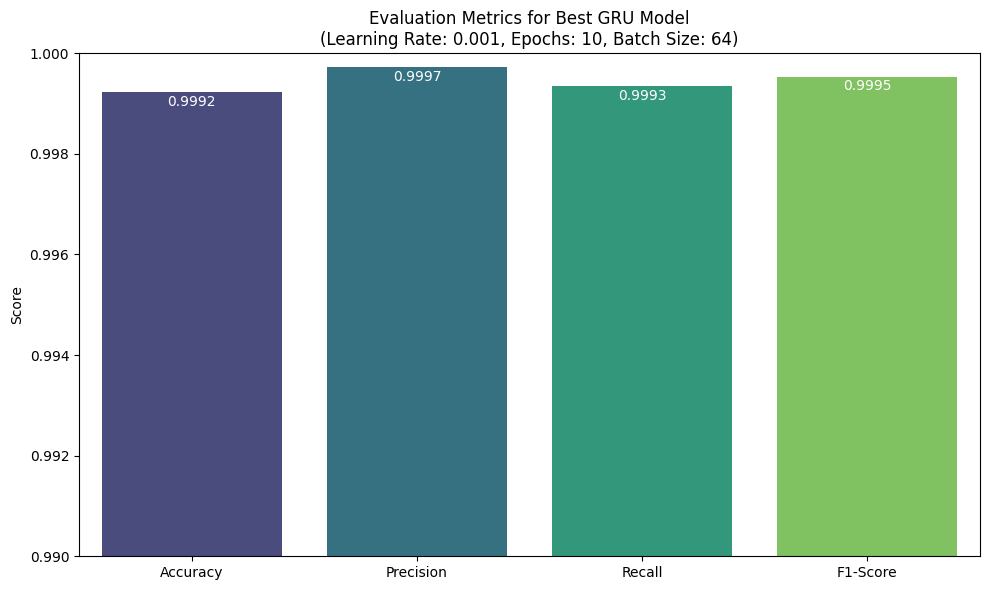

In [8]:
# Prepare evaluation metrics for plotting (CNN)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [best_model['Accuracy'], best_model['Precision'], best_model['Recall'], best_model['F1-Score']]

# Plot the evaluation metrics as a barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values, hue=metrics, palette='viridis', legend=False)

# Add labels inside the bars, closer to the top
for i, value in enumerate(values):
    plt.text(i, value - 0.00005 , f'{value:.4f}', ha='center', va='top', color='white')

# Set the y-axis to start from 0.99
plt.ylim(0.99, 1.0)

# Add plot title and labels — updated for CNN
plt.title(
    f"Evaluation Metrics for Best GRU Model\n"
    f"(Learning Rate: {best_model['learning_rate']}, Epochs: {best_model['epochs']}, Batch Size: {best_model['batch_size']})"
)
plt.ylabel("Score")
plt.tight_layout()
plt.show()

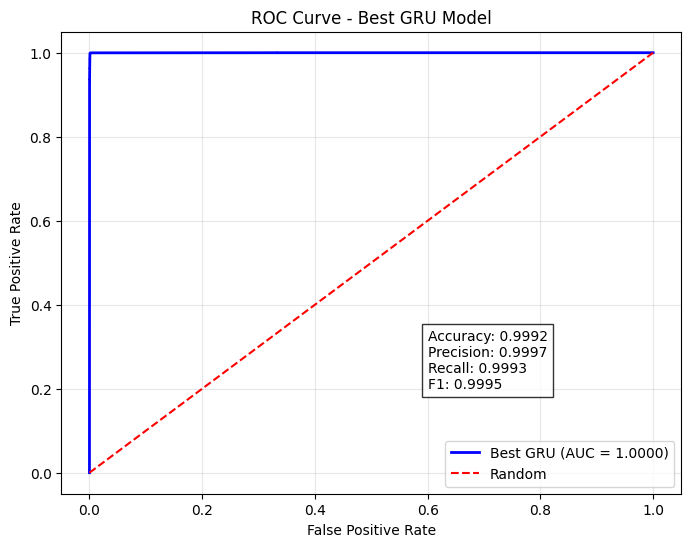

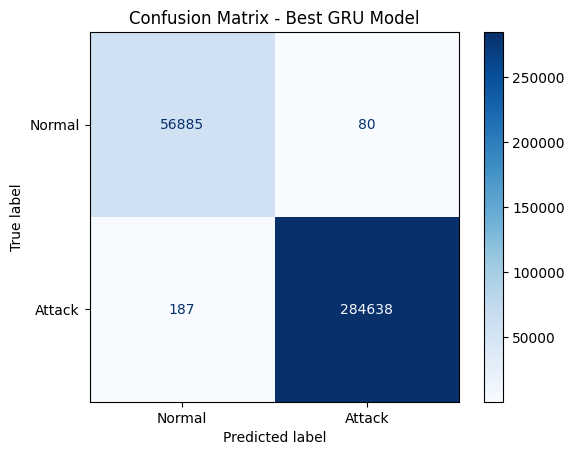

In [ ]:
# ==== Load ROC  ====
best_model_roc_fpr_gru = np.load(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\GRU\best_model_roc_fpr.npy', allow_pickle=True)
best_model_roc_tpr_gru = np.load(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\GRU\best_model_roc_tpr.npy', allow_pickle=True)
best_model_roc_auc_gru = np.load(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\GRU\best_model_roc_auc.npy', allow_pickle=True)

# ==== ROC Curve  ====
plt.figure(figsize=(8, 6))
plt.plot(best_model_roc_fpr_gru, best_model_roc_tpr_gru, 'b-', linewidth=2, label=f'Best GRU (AUC = {best_model_roc_auc_gru:.4f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best GRU Model')
plt.legend()
plt.grid(alpha=0.3)

plt.text(0.6, 0.2, f'Accuracy: {best_model_df_gru["Accuracy"].values[0]:.4f}\n'
                   f'Precision: {best_model_df_gru["Precision"].values[0]:.4f}\n'
                   f'Recall: {best_model_df_gru["Recall"].values[0]:.4f}\n'
                   f'F1: {best_model_df_gru["F1-Score"].values[0]:.4f}',
         bbox=dict(facecolor='white', alpha=0.8))
plt.show()

# ==== Confusion Matrix ====
cm_gru = np.array(best_model_result_gru['Confusion_Matrix'])  
if cm_gru.ndim == 3: 
    cm_gru = cm_gru[0]
disp_gru = ConfusionMatrixDisplay(confusion_matrix=cm_gru, display_labels=['Normal', 'Attack'])
disp_gru.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Best GRU Model')
plt.grid(False)
plt.show()
